In [278]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')


In [206]:
# # download dataset from huggingface
# from huggingface_hub import snapshot_download
# snapshot_download(repo_id="Gae8J/Gaepago",repo_type='dataset',local_dir = "download_dir")

# Get downloaded wav ids

In [227]:
# 
wav_path = pathlib.Path('./download_dir/raw/wav/').glob('**/*')
dowloaded_raw_paths = [wav for wav in wav_path if wav.is_file()]

#
wav_ids = [ file_path.name.split('.wav')[0] for file_path in dowloaded_raw_paths if '.wav' in file_path.name] 
print(wav_ids[0:5])
print('The number of wav ids of .wav file:', len(wav_ids))
print('The number of unique wav ids of .wav file:', len(set(wav_ids)))

['2mJbGx5D-zA', 'FTYgwHJUkaY', 'raww5tvi85A', 'wSDDZL5mauE', '1PxKjFulkLs']
The number of wav ids of .wav file: 643
The number of unique wav ids of .wav file: 357


# Make info dataframe 

In [228]:
#
balanced_trained_segments = pd.read_csv('./metadata/balanced_train_segments.csv', sep=',', quotechar='"', skipinitialspace=True)
balanced_trained_segments['src'] = 'balanced_trained_segments'
eval_segments = pd.read_csv('./metadata/eval_segments.csv', sep=',', quotechar='"', skipinitialspace=True)
eval_segments['src'] = 'eval_segments'
unbalanced_train_segments = pd.read_csv('./metadata/unbalanced_train_segments.csv', sep=',', quotechar='"', skipinitialspace=True)
unbalanced_train_segments['src'] = 'unbalanced_train_segments'

df = pd.concat([balanced_trained_segments, eval_segments, unbalanced_train_segments], axis=0).reset_index(drop=True)
df = df[df.YTID.isin(wav_ids)].reset_index(drop=True)

# 
labels = pd.read_csv('./metadata/class_labels_indices.csv', sep=',')
prefix_sounds = ['Bark', 'Bow-wow', 'Growling', 'Howl', 'Whimper (dog)', 'Yip']
labels = labels[labels.display_name.isin(prefix_sounds)].reset_index(drop=True)
for idx in range(len(df)):
    mids = df.iloc[idx]["positive_labels"].split(',')
    text_label = list(set([ list(labels[labels.mid == mid]['display_name']).pop() for mid in mids if mid in list(labels['mid'])]))
    
    df['positive_labels'][idx] = ",".join(text_label)

print('The number of matching info ids:', len(df))
print(f"There are {set(list(df['src']))} dataset exist", )
print(f'balanced_trained_segments #{len(balanced_trained_segments)}, eval_segments #{len(eval_segments)}')

The number of matching info ids: 357
There are {'eval_segments', 'balanced_trained_segments'} dataset exist
balanced_trained_segments #22160, eval_segments #20371


In [229]:
df.head()

,YTID,start_seconds,end_seconds,positive_labels,src
0,-G3Ph35cTy0,30.0,40.0,Whimper (dog),balanced_trained_segments
1,-ODzHayGHvk,50.0,60.0,Growling,balanced_trained_segments
2,-QVqh513RxQ,15.0,25.0,Whimper (dog),balanced_trained_segments
3,-Ry1YNVPPCM,9.0,19.0,"Whimper (dog),Bow-wow",balanced_trained_segments
4,-hDuDDv0lbQ,30.0,40.0,"Yip,Howl",balanced_trained_segments


# EDA

##### Figure out duration each source(balanced_trained_segments, eval_segments, unbalanced_train_segments)


([<matplotlib.axis.XTick at 0x7f5692606a60>,
 [Text(1, 0, 'balanced_trained_segments'), Text(2, 0, 'eval_segments')])

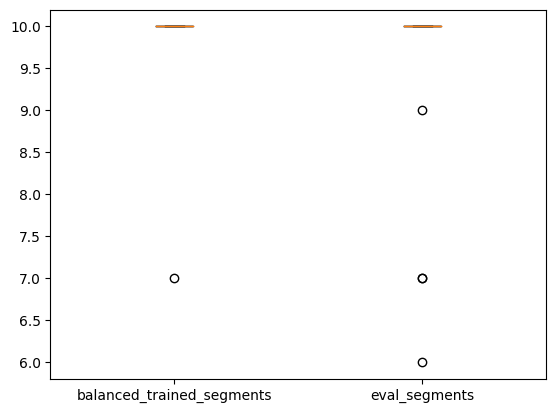

In [133]:
# figure out duration each source(balanced_trained_segments, eval_segments, unbalanced_train_segments)
sub_df = df[['start_seconds', 'end_seconds', 'src']]
sub_df['duration'] = sub_df['end_seconds'] - sub_df['start_seconds']

balanced_trained_segments_duration = sub_df[sub_df.src == 'balanced_trained_segments']['duration']
eval_segments_duration = sub_df[sub_df.src == 'eval_segments']['duration']
# unbalanced_train_segments_duration = sub_df[sub_df.src == 'unbalanced_train_segments']['duration']

fig,ax = plt.subplots()
ax.boxplot([list(balanced_trained_segments_duration), list(eval_segments_duration)])
plt.xticks([1, 2], ['balanced_trained_segments', 'eval_segments'])

##### The number of data for each class 

In [266]:
prefix_sounds = ['Bark', 'Bow-wow', 'Growling', 'Howl', 'Whimper (dog)', 'Yip']


for src in ['balanced_trained_segments', 'eval_segments']:
    _df = df[df['src'] == src].reset_index(drop=True)
    for sound in prefix_sounds:
        if sound == 'Whimper (dog)':
            sound = 'Whimper'
        
        count = sum(_df['positive_labels'].str.contains(sound))

        print(f'{src}: The number of {sound} is {count}')

balanced_trained_segments: The number of Bark is 52
balanced_trained_segments: The number of Bow-wow is 55
balanced_trained_segments: The number of Growling is 51
balanced_trained_segments: The number of Howl is 16
balanced_trained_segments: The number of Whimper is 50
balanced_trained_segments: The number of Yip is 52
eval_segments: The number of Bark is 50
eval_segments: The number of Bow-wow is 61
eval_segments: The number of Growling is 56
eval_segments: The number of Howl is 14
eval_segments: The number of Whimper is 48
eval_segments: The number of Yip is 52


##### Check multi-label of data

average of total 1.5602240896358543
average of balanced_trained_segments 1.4759358288770053
average of eval_segments 1.6529411764705881


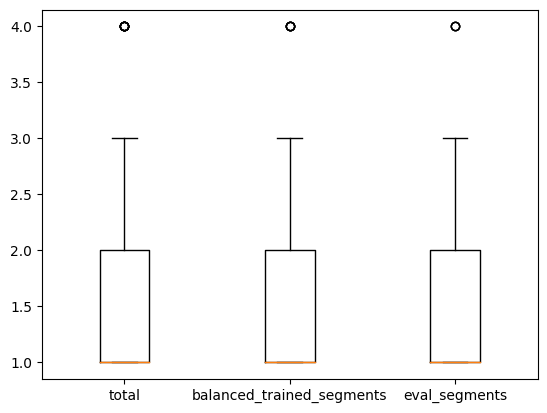

In [279]:
df['nClass'] = df['positive_labels'].apply(lambda x: x.count(',') + 1)

total = list(df['nClass'])
balanced_trained_segments = list(df[df['src'] == 'balanced_trained_segments']['nClass'])
eval_segments = list(df[df['src'] == 'eval_segments']['nClass'])

fig,ax = plt.subplots()
ax.boxplot([total, balanced_trained_segments, eval_segments])
plt.xticks([1, 2, 3], ['total', 'balanced_trained_segments', 'eval_segments'])
print('average of total', np.mean(total))
print('average of balanced_trained_segments', np.mean(balanced_trained_segments))
print('average of eval_segments', np.mean(eval_segments))

##### Plot frequency of audio

##### mel spectrogram